In [1]:
machine = 'mac'
machine = 'magny'

In [2]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import copy

from areposnap.gadget import gadget_readsnap
from areposnap.gadget_subfind import load_subfind

from auriga_basics import *
from auriga_functions import *
%matplotlib inline

In [3]:
#### path = /hits/universe/GigaGalaxy/level4_MHD/halo_24/output/*
level = 4
if machine == 'magny':
    basedir = "/hits/universe/GigaGalaxy/level4_MHD/"
elif machine == 'mac': 
    basedir = "/Users/smilanov/Desktop/Auriga/level4/"
j = 0
for halo_number in [24]:  # range(1, 31):
    halodir = basedir+"halo_{0}/".format(halo_number)
    snappath = halodir+"output/"
    '''
    s_main, sf_main =  eat_snap_and_fof(level, halo_number, 127, snappath, loadonlytype=[4], 
            haloid=0, galradfac=0.1, verbose=True) 
    s_main.data['gmet'] = np.maximum( s_main.data['gmet'], 1e-40 )
    istars, = np.where( (s.type == 4) & (s.halo == 0) )
    (x_main_Mpc, y_main_Mpc, z_main_Mpc), (vx_main_Mpc, vy_main_Mpc, vz_main_Mpc), rxyz_main_Mpc, rxy_main_Mpc = get_cartesian_vectors(s, sf, istars)
    '''
    for snapnr in [127]:
        print("level   : {0}".format(level))
        print("halo    : {0}".format(halo_number))
        print("snapnr  : {0}".format(snapnr))
        print("basedir : {0}".format(basedir))
        print("halodir : {0}".format(halodir))
        print("snappath: {0}\n".format(snappath))
        s, sf = eat_snap_and_fof(level, halo_number, snapnr, snappath, loadonlytype=[4], 
            haloid=0, galradfac=0.1, verbose=True) 

        # Clean negative and zero values of gmet to avoid RuntimeErrors
        # later on (e.g. dividing by zero)
        s.data['gmet'] = np.maximum( s.data['gmet'], 1e-40 )

level   : 4
halo    : 24
snapnr  : 127
basedir : /hits/universe/GigaGalaxy/level4_MHD/
halodir : /hits/universe/GigaGalaxy/level4_MHD/halo_24/
snappath: /hits/universe/GigaGalaxy/level4_MHD/halo_24/output/

[ 34.42281723  33.16259384  37.29567337]
Found 1783163 stars.
Rotated pos.
Rotated vel.

galrad  : 0.02408556640148163
redshift: 2.220446049250313e-16
time    : 0.9999999999999998
center  : [ 0.  0.  0.]



In [11]:
def dwarf_selection(s, sf, z_kpc_val, level, halo_number, snapnr, snappath, subhalonr, partnr, outplot = True, outfile = False):
    '''
    NAME: 
        dwarf_selection
    INPUT:
        s, sf: z=0 snapshot
        z_kpc: absolute disk height in kpc
        level, halo_number, snapnr, snappath: snapshot in which dwarf is selected (INT; 0 < snapnr < 127)
        subhalonr: which subhalo should be selected (INT; 0 < subhalonr)
        partnr: number of random selected dwarf particles (INT)
        outplot: if True, plots marked dwarf in early and z=0 snapshot; default = True
        outfile: if True, saves information on dwarfs in file; default = False
    HISTORY:
        02-02-2018: written (Milanov, ESO)
    '''
    # read in early snapshot
    es, esf = eat_snap_and_fof(level, halo_number, snapnr, snappath, loadonlytype=[4], 
            haloid=0, galradfac=0.1, verbose=True)   
    es.data['gmet'] = np.maximum( es.data['gmet'], 1e-40 )
    
    # select dwarf galaxy and pick random particles 
    # MAYBE JUST SELECT ALL PARTICLES AND IN THE END JUST KEEP THE ONES OUTSIDE THE DISK
    # ALSO INTERESTING MIGHT BE THE SURVIVING FRACTION
    # SAVE IDS, SNAPNR IN A FILE 
    istarssub, = np.where( (es.type == 4) & (es.halo == 0) & (es.subhalo == subhalonr) )
    istarssubsample = np.random.choice(istarssub, partnr)
    #istarssubsample = np.where( (es.type == 4) & (es.halo == 0) & (es.subhalo == 1) & (1000. * np.abs(es.pos[::,0]) > z_kpc))
    ids_halo1 = es.id[istarssubsample]
    ids_halo1 = es.id[istarssub]
    
    
    istars, = np.where( (s.type == 4) & (s.halo == 0) )
    (x_kpc, y_kpc, z_kpc), (vx_kpc, vy_kpc, vz_kpc), rxyz_kpc, rxy_kpc = get_cartesian_vectors(s, sf, istars)
    istarse, = np.where( (es.type == 4) & (es.halo == 0) )
    (ex_kpc, ey_kpc, ez_kpc), (evx_kpc, evy_kpc, evz_kpc), erxyz_kpc, erxy_kpc = get_cartesian_vectors(es, esf, istarse)
        
    subhalomask = np.isin(s.id[istars], ids_halo1)
    esubhalomask = np.isin(es.id[istarse], ids_halo1)
    z_sample = np.where((np.abs(z_kpc) > z_kpc_val) & (rxyz_kpc < 5. * 1000. * s.galrad), True, False)
    
    survivors = np.sum(z_sample * subhalomask)
    starters = np.sum(esubhalomask)

    print('Snapshot number:', snapnr,'\nfraction:', survivors , starters, round(survivors/starters, 2), '\n')
    if outplot == True:
        fig, axes = plt.subplots(2, 2, figsize=(12, 12))     
        axes[0, 0].set_title(str(snapnr))
        axes[0, 0].hist2d(ex_kpc, ey_kpc, bins=401, norm=matplotlib.colors.LogNorm(), cmap = 'Greys')
        axes[0, 0].plot(ex_kpc[esubhalomask], ey_kpc[esubhalomask], 'r.', alpha = 0.3)
        axes[0, 0].set_xlabel("x")
        axes[0, 0].set_ylabel("y")
        axes[0, 0].set_aspect('equal')
        axes[0, 1].hist2d(erxy_kpc, ez_kpc, bins=401, norm=matplotlib.colors.LogNorm(), cmap = 'Greys')
        axes[0, 1].plot(erxy_kpc[esubhalomask], ez_kpc[esubhalomask], 'r.', alpha = 0.3)
        axes[0, 1].set_xlabel("R")
        axes[0, 1].set_ylabel("z")
        axes[0, 1].set_aspect('equal')
        
        axes[1, 0].hist2d(x_kpc, y_kpc, bins=401, norm=matplotlib.colors.LogNorm(), cmap = 'Greys')
        axes[1, 0].plot(x_kpc[z_sample * subhalomask], y_kpc[z_sample * subhalomask], 'r.', alpha = 0.3)
        axes[1, 0].set_xlabel("x")
        axes[1, 0].set_ylabel("y")
        axes[1, 0].set_aspect('equal')
        axes[1, 1].hist2d(rxy_kpc, z_kpc, bins=401, norm=matplotlib.colors.LogNorm(), cmap = 'Greys')
        axes[1, 1].plot(rxy_kpc[z_sample * subhalomask], z_kpc[z_sample * subhalomask], 'r.', alpha = 0.3)
        axes[1, 1].set_xlabel("R")
        axes[1, 1].set_ylabel("z")
        axes[1, 1].set_aspect('equal')
        #fig.show()
        
    
    if outfile == True:
        with open('/home/extmilan/masterthesis/files/.txt','ab') as f:
            for iind in range(4):
                a=np.random.rand(10,10)
                print(a)
                np.savetxt(f,a)


[ 7.21020699  6.89154625  7.28530788]
Found 6825 stars.
Rotated pos.
Rotated vel.

galrad  : 0.00284971334040165
redshift: 3.7087742646422353
time    : 0.21236949231329916
center  : [ 0.  0.  0.]

Snapshot number: 50 
fraction: 129 4843 0.03 

[ 7.92679119  7.58518696  8.0392313 ]
Found 11260 stars.
Rotated pos.
Rotated vel.

galrad  : 0.003852377459406853
redshift: 3.2830330579565246
time    : 0.23347940267290615
center  : [ 0.  0.  0.]

Snapshot number: 52 
fraction: 276 2922 0.09 

[ 8.7214613   8.35234547  8.85930157]
Found 33710 stars.
Rotated pos.
Rotated vel.

galrad  : 0.004613281413912773
redshift: 2.8957850057274284
time    : 0.2566876761756205
center  : [ 0.  0.  0.]

Snapshot number: 54 
fraction: 294 2121 0.14 

[ 9.50209332  9.11564541  9.67981148]
Found 41264 stars.
Rotated pos.
Rotated vel.

galrad  : 0.005203771591186524
redshift: 2.5772902716018935
time    : 0.27954119573086944
center  : [ 0.  0.  0.]

Snapshot number: 56 
fraction: 782 7380 0.11 

[ 10.25568104   9.8

/home/extmilan/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


[ 21.73373222  20.98360252  22.89403915]
Found 1283929 stars.
Rotated pos.
Rotated vel.

galrad  : 0.018386109173297884
redshift: 0.5759808451078874
time    : 0.6345254785958663
center  : [ 0.  0.  0.]

Snapshot number: 92 
fraction: 6 39967 0.0 

[ 22.47373009  21.69274902  23.72468185]
Found 1349298 stars.
Rotated pos.
Rotated vel.

galrad  : 0.01891210824251175
redshift: 0.524565820433923
time    : 0.6559244517992534
center  : [ 0.  0.  0.]

Snapshot number: 94 
fraction: 9 43920 0.0 

[ 23.13161278  22.31706619  24.45867538]
Found 1400280 stars.
Rotated pos.
Rotated vel.

galrad  : 0.019676823914051057
redshift: 0.4818329434209512
time    : 0.6748399031346985
center  : [ 0.  0.  0.]

Snapshot number: 96 
fraction: 8 44143 0.0 

[ 23.80860329  22.96368408  25.21352386]
Found 1428816 stars.
Rotated pos.
Rotated vel.

galrad  : 0.02028559446334839
redshift: 0.4402978492477432
time    : 0.6943008354294861
center  : [ 0.  0.  0.]

Snapshot number: 98 
fraction: 4 43341 0.0 



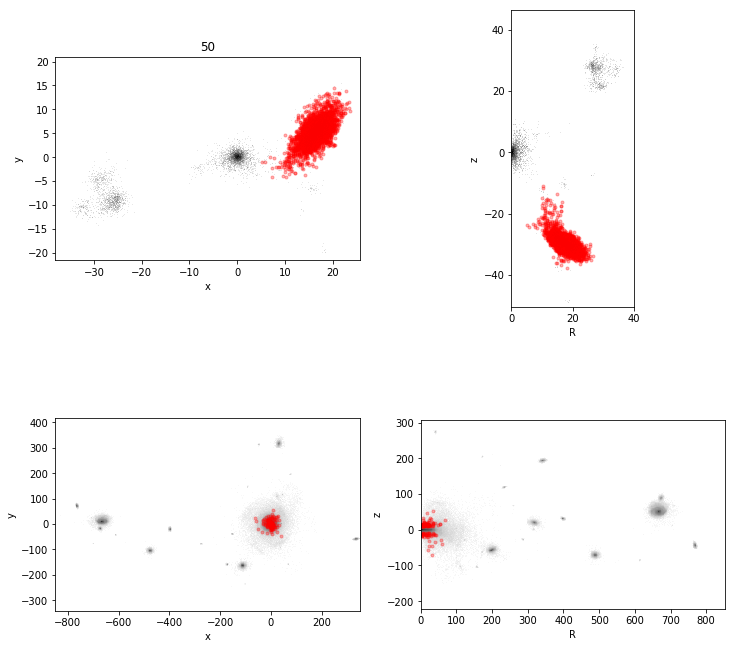

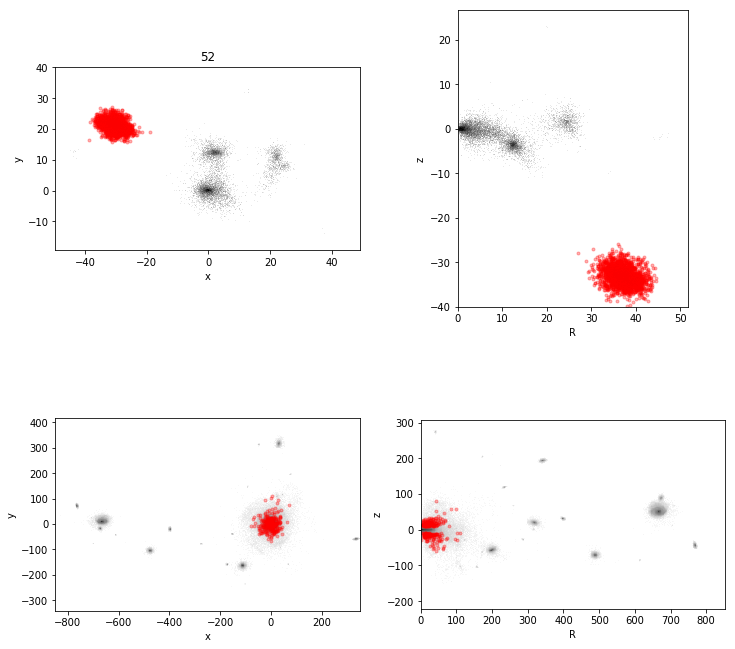

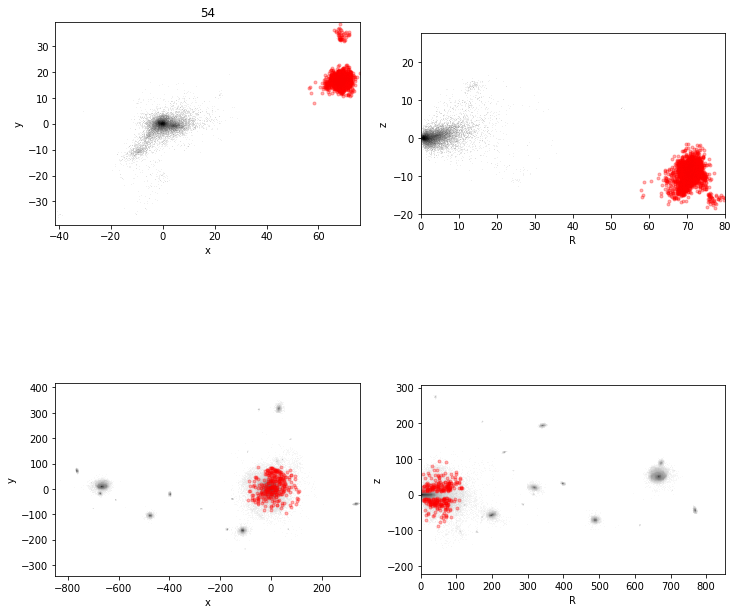

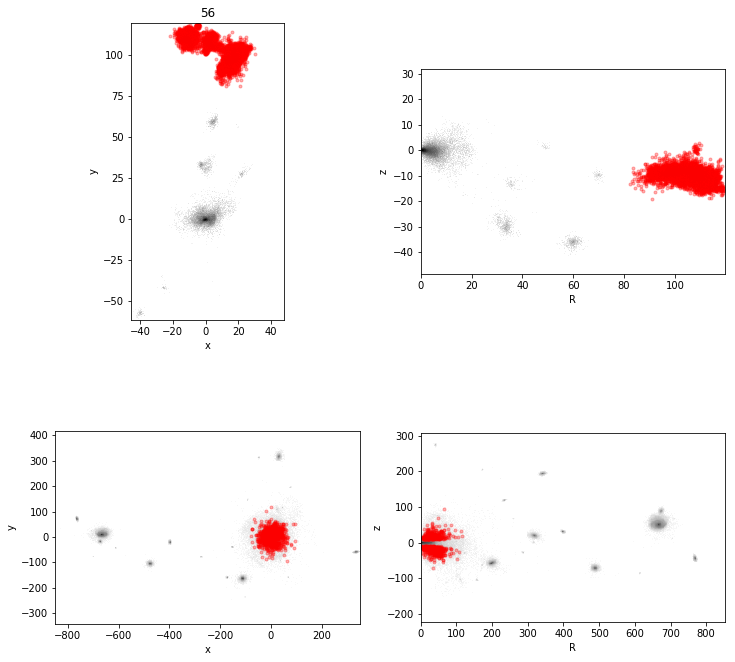

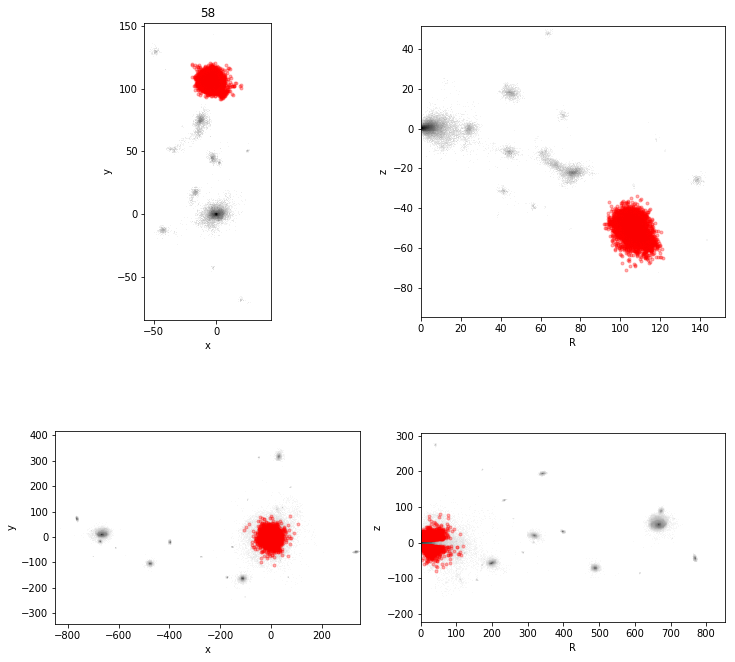

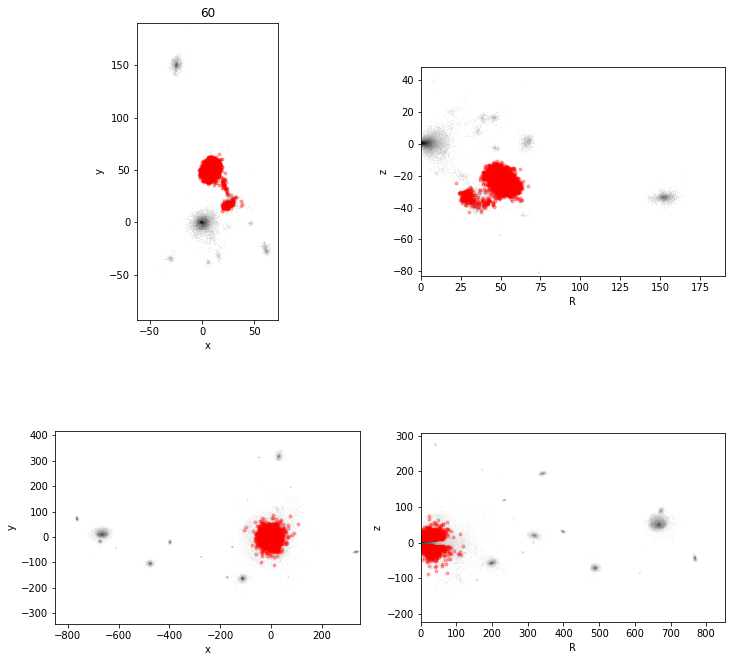

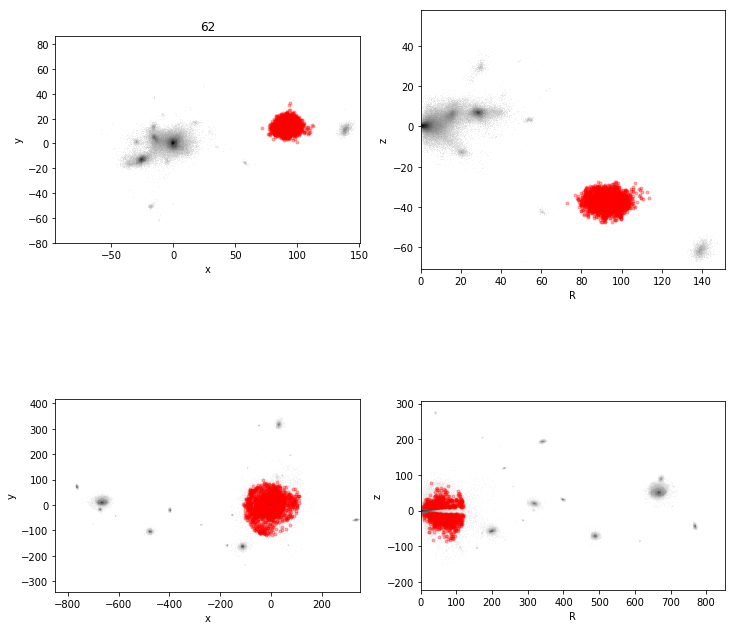

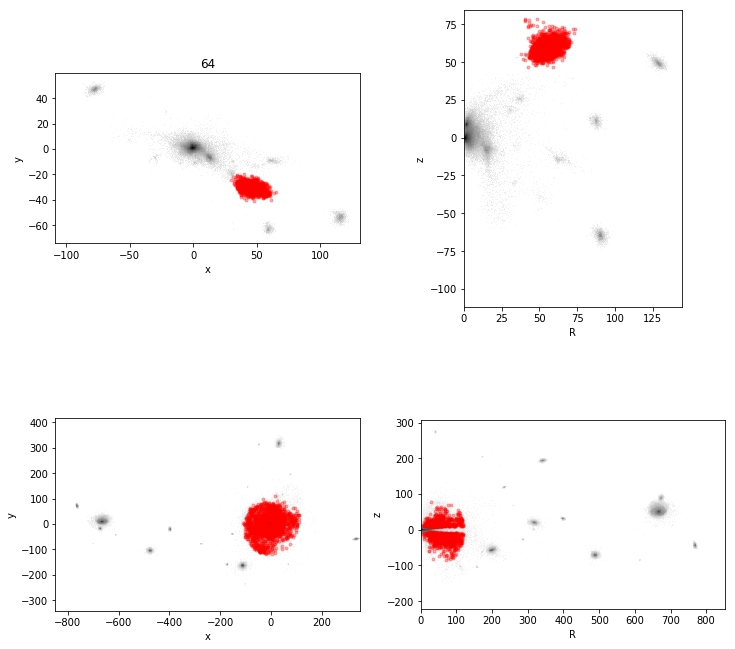

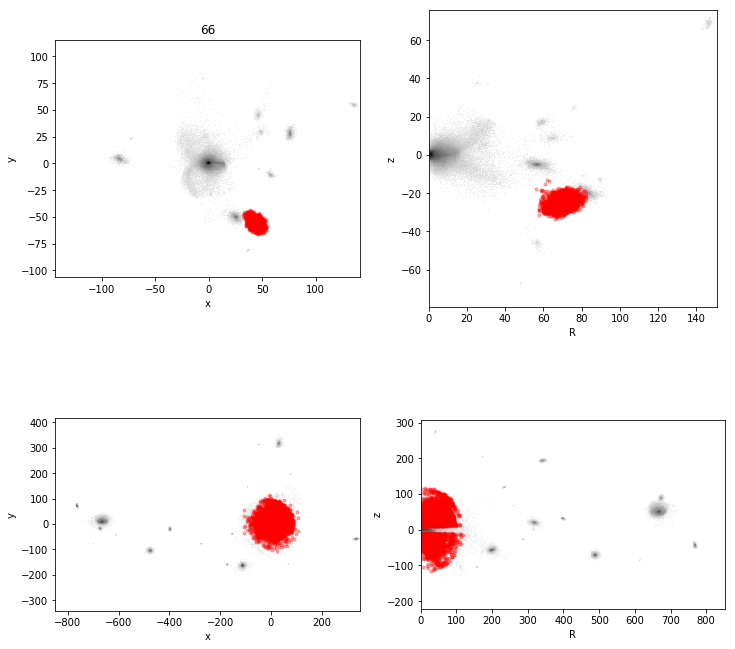

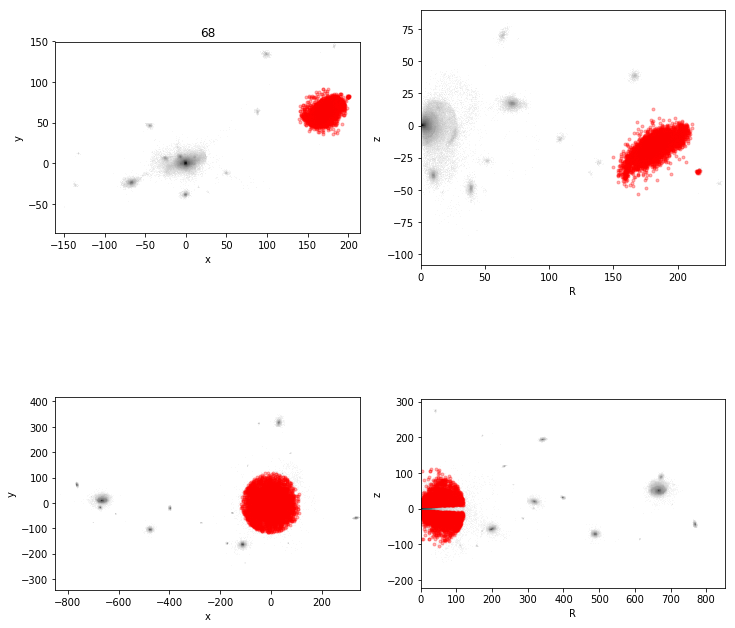

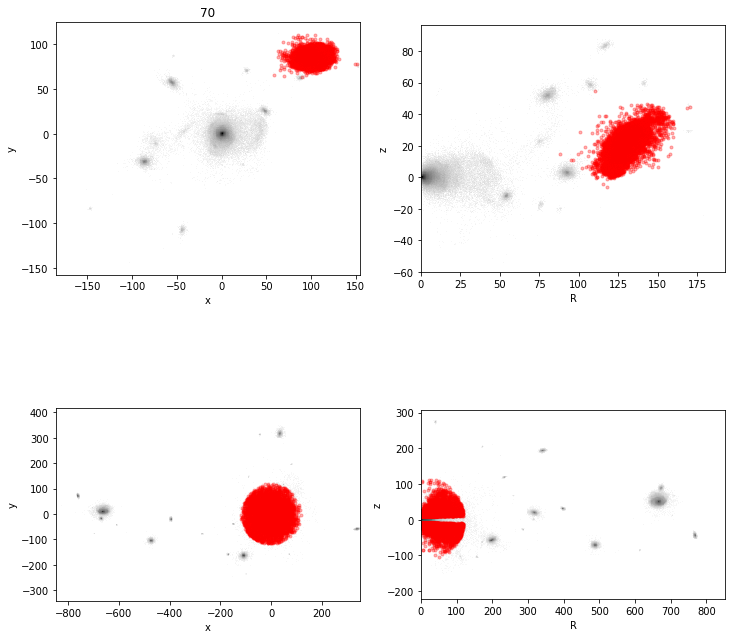

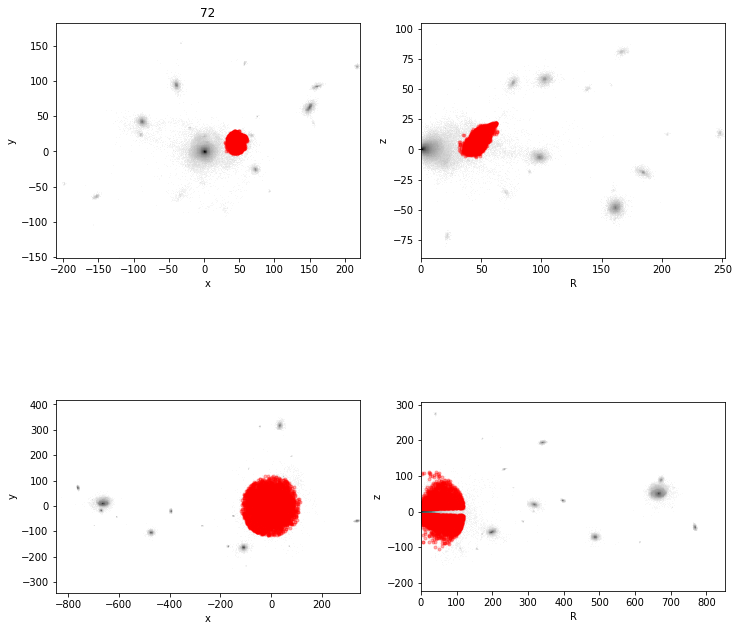

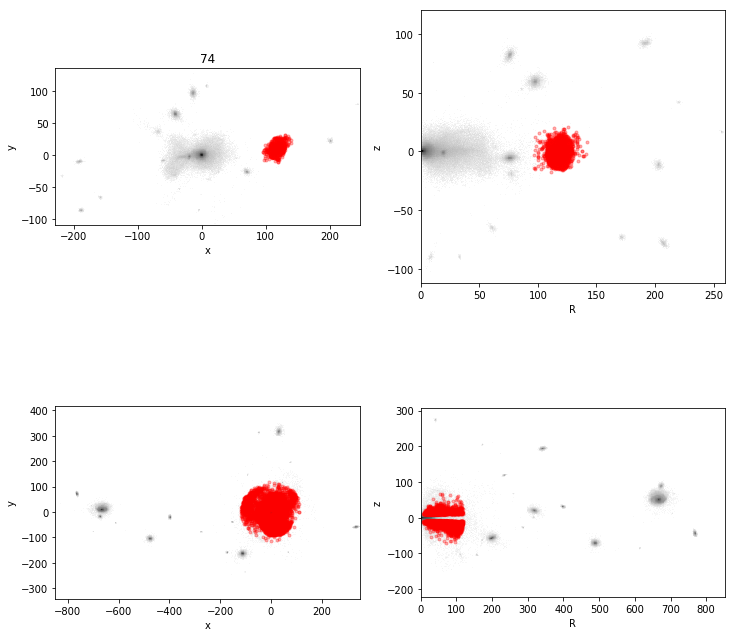

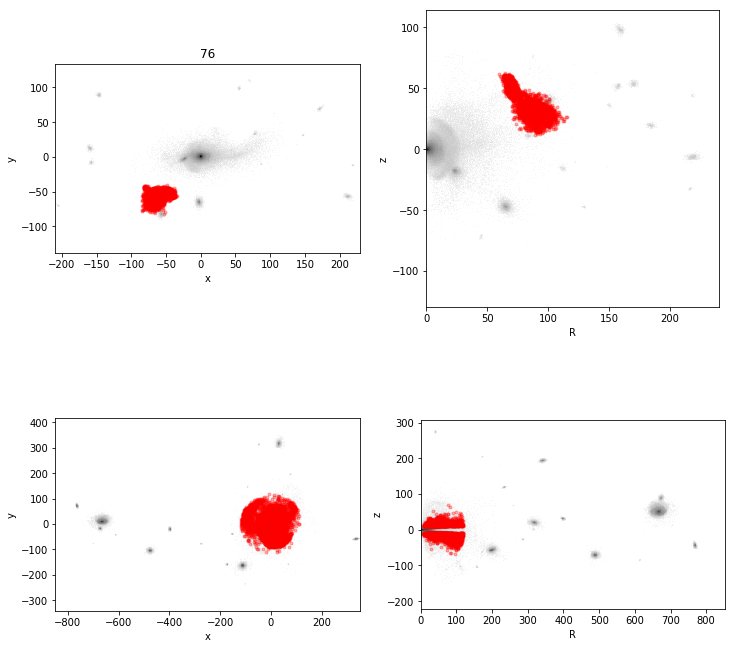

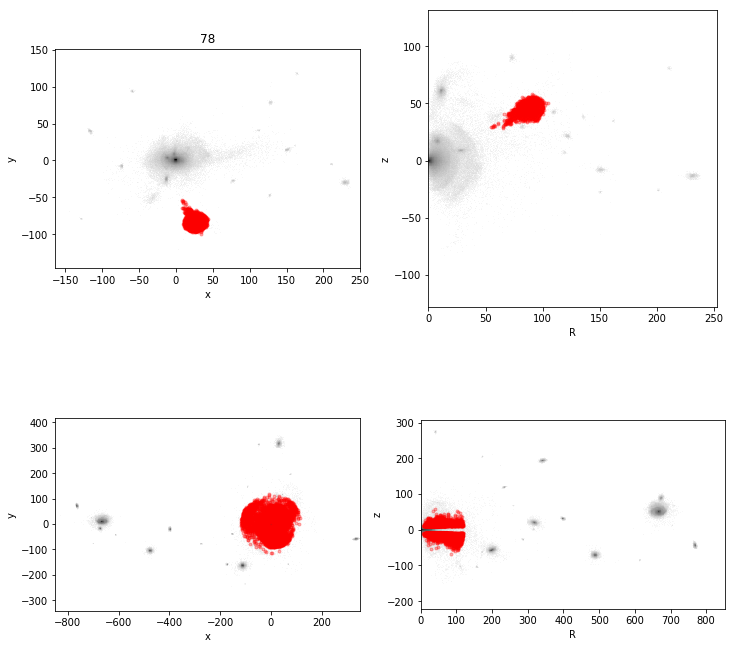

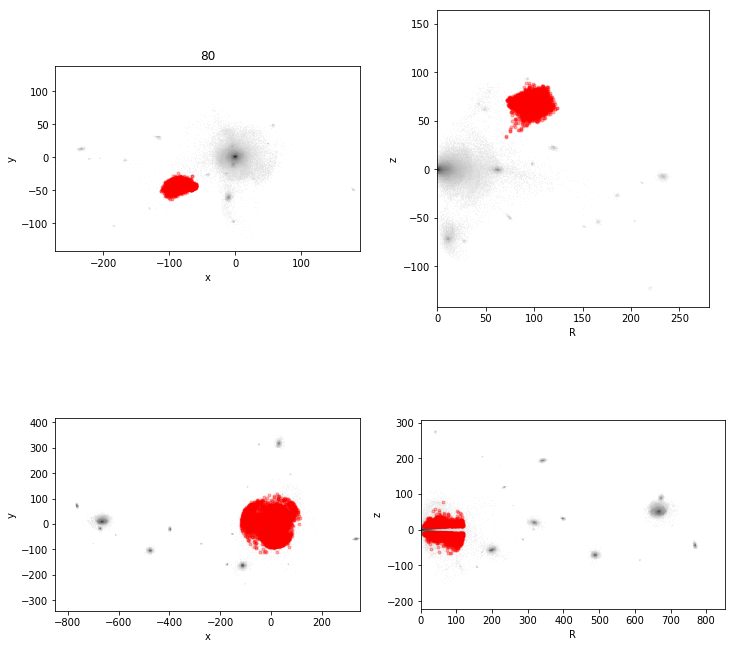

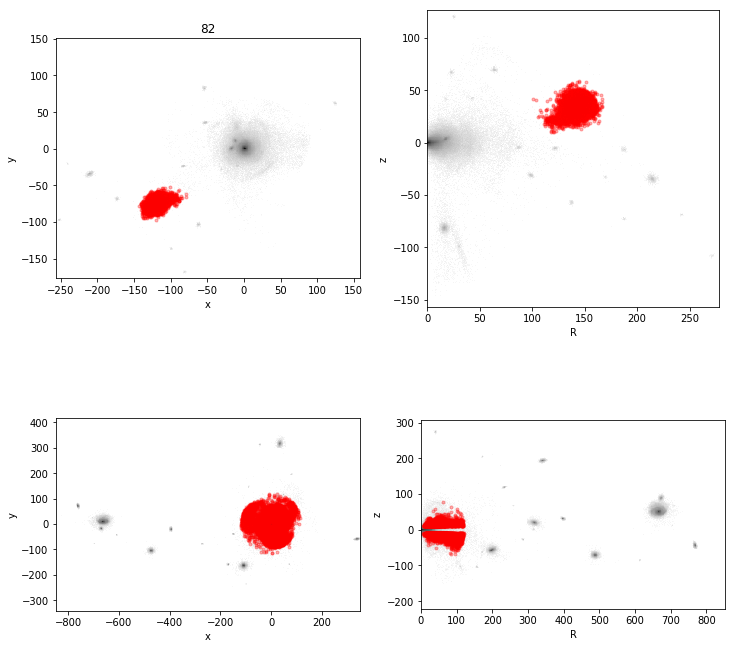

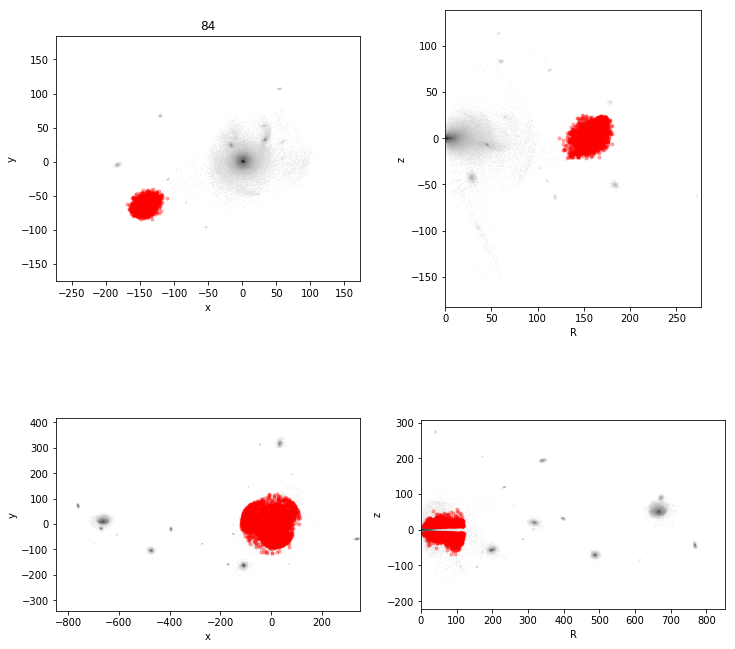

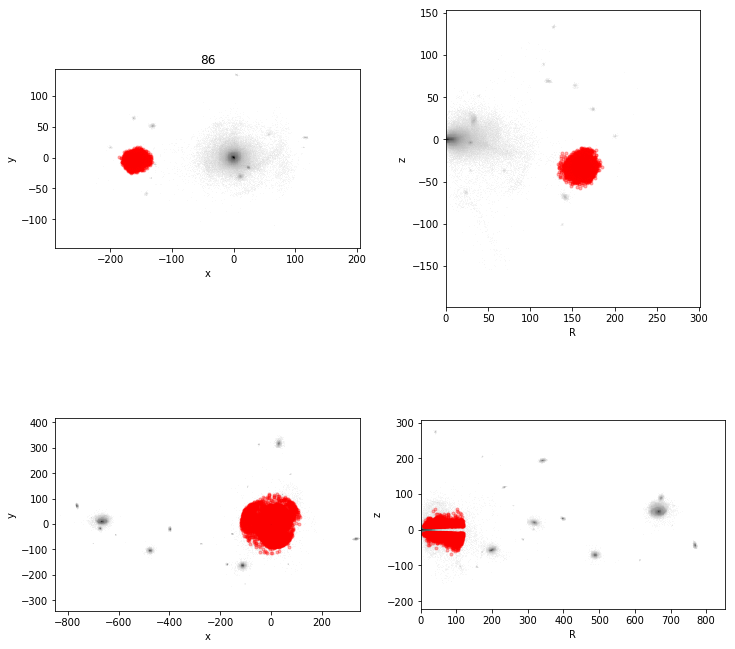

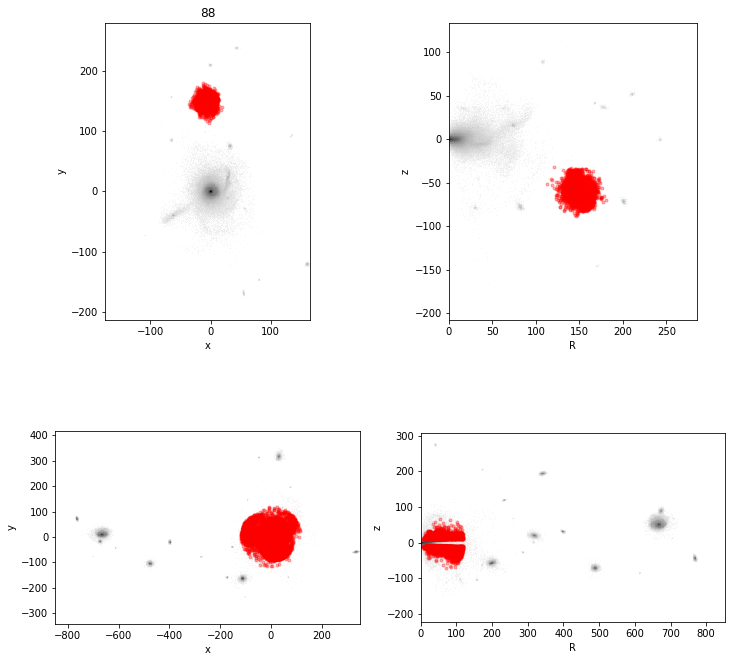

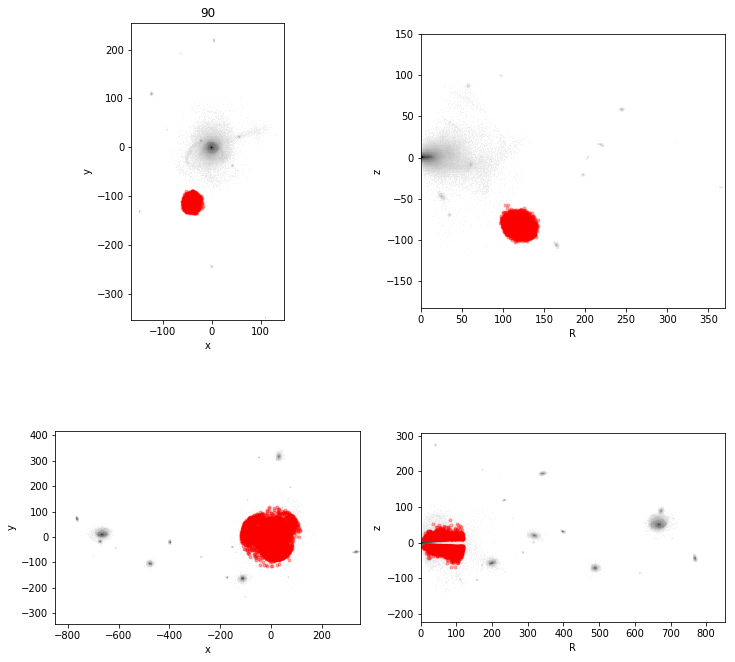

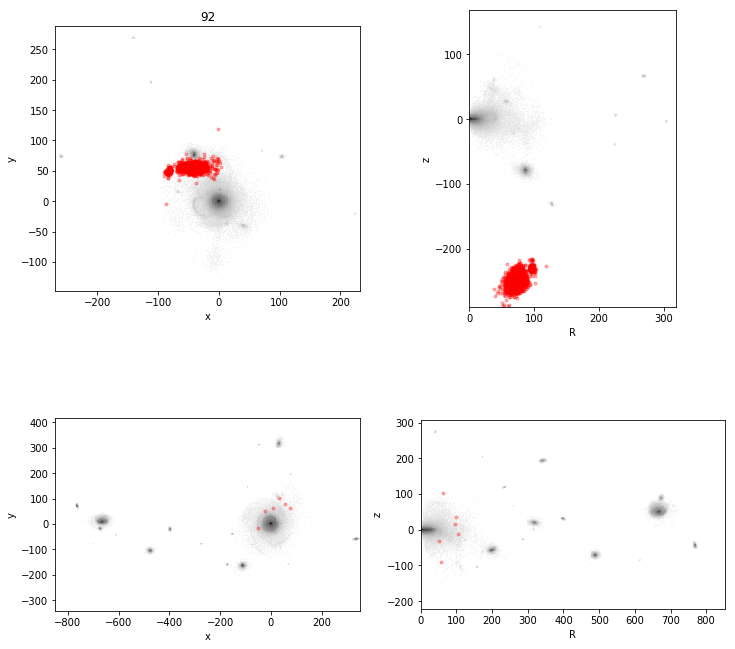

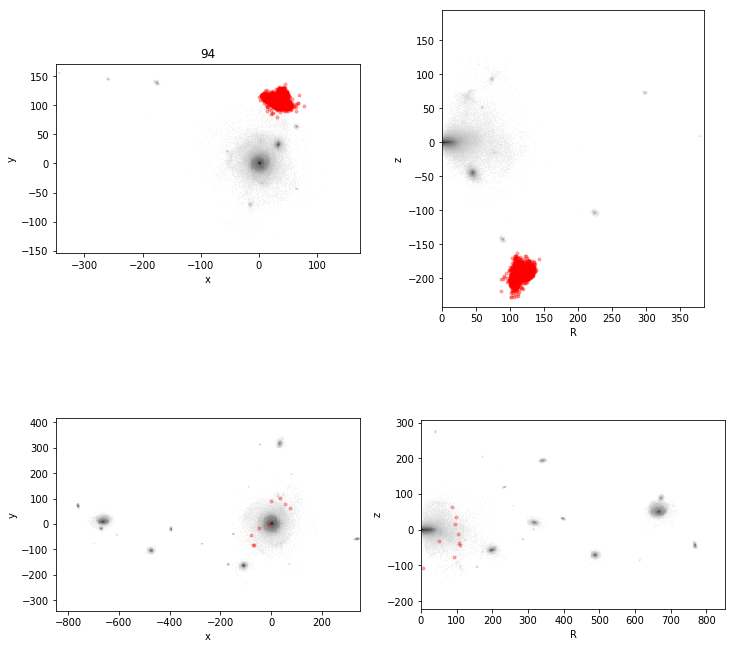

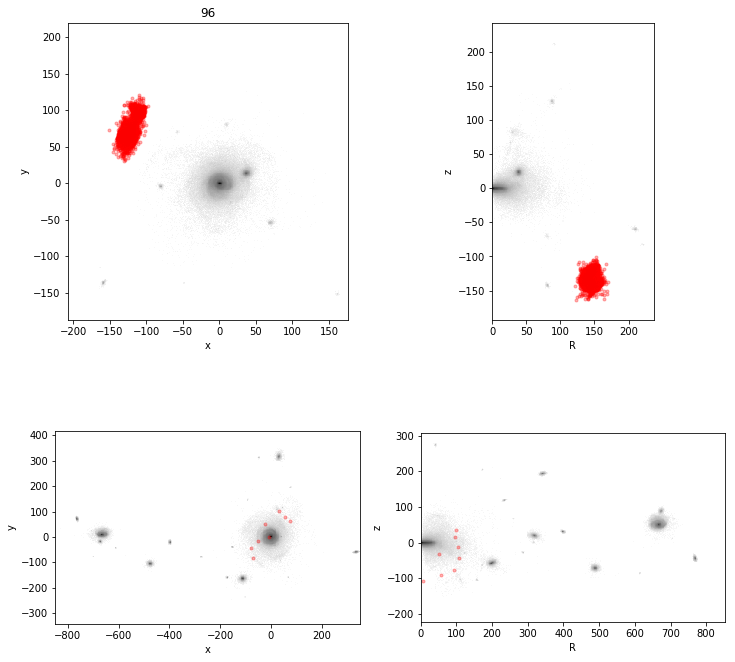

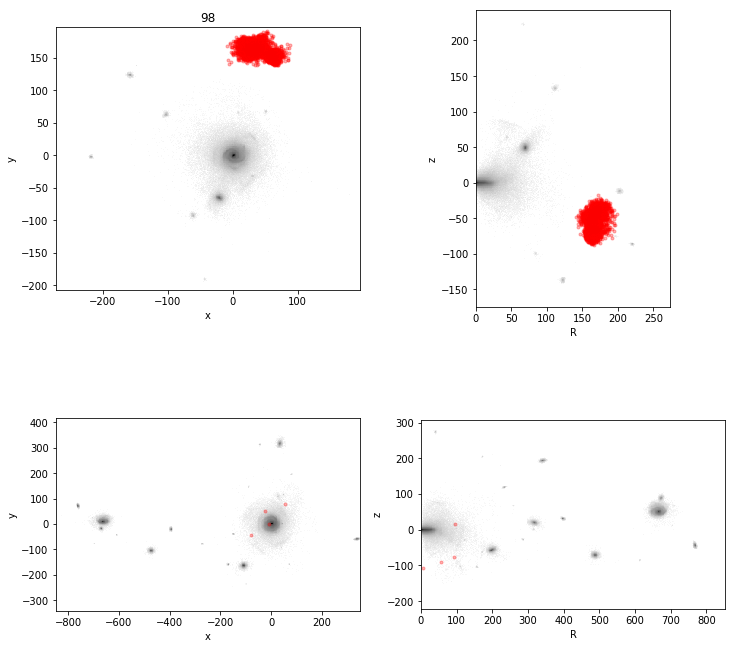

In [12]:
halo_number = 24
halodir = basedir+"halo_{0}/".format(halo_number)
snappath = halodir+"output/"

for i in range(50,100,2):
    dwarf_selection(s, sf, 10., level, halo_number, i, snappath, 1, 50)